# Modified version of:
https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb 



### CNN with Image Augmentation (CIFAR10)
images of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. In RGB, 32x32 pixels. 


Naszym zadaniem jest zbudować jak najbardziej wydajny program do klasyfikacji zdjęć uczący się na bardzo małej próbce danych. Proponuję użyć rozmiarów próbek treningowych:

1.    500 obrazków
2.   1000 obrazków
3.   5000 obrazków.
Za każdym razem używamy 10 000 przypadków jako zbioru testowego. Selekcjonujemy z danych tylko trzy klasy obrazków: samochody, ptaki i samoloty (żeby było łatwiej).

To jest tylko szkielet programu - dokonuje klasyfikacji, ale jest daleki od optimum.

**Państwa zadaniem jest:**

1.   Dodać modyfikację obrazów (augmentacja). Jest to zrobione w formie szkieletowej, wariancje parametrów wynoszą zero. Proponuję na początek zmieniać (ta sama zmienna dla dwóch przesunięć i powiększenia):
  *   rotation_range=rotation_range,
  *    width_shift_range=shift_range,
  *    height_shift_range=shift_range,
  *    zoom_range=shift_range  
Oczywiście można potem zwiększyć liczbę optymalizowanych parametrów. 
2. Dodać K-folding np. 5-krotny. Walidację przeprowadamy na 1/5 zbioru treningowego, uczenie na 4/5. Końcowy klasyfikator jest uśrednionym klasyfikatorem z tych pięciu.
3. Dodać optymalizację. Optymalizujemy w pierwszym podejściu trzy zmienne:
  *   rotation_range
  *   shift_range
  *   num_filters - liczba filtrów w warstwie ukrytej.

  Optymalizujemy **bez użycia** danych testowych, tylko posiłkując się danymi walidacyjnym z k-folding. Można optymalizować np. średnią dokładność (accuracy) wszystkich pięciu sieci z k-foldingu. Optymalizację można najpierw prowadzić dla 5 kroków, jak program będzie już działać to dla 30-50 kroków
4. Dla optymalnych parametrów przeprowadzić końcowy trening, narysować "accuracy" dla wszystkich sieci z k-foldingu i zbudować końcowy klasyfikator (średnia z wszystkich klasyfikatorów z k-foldingu).
5. Znaleźć "accuracy" oraz "confusion matrix" dla końcowego klasyfikatora. 
6. Można powtórzyć dla innej liczby obrazków w zbiorze treningowym. 

7. Można optymalizować także:
*  drop_dense2
*  drop_conv2
*  liczbę "bloków" w sieci konwolucyjnej (obecnie trzy)

8. UWAGA: sieć zoptymalizowana dla małej liczby obrazków treningowych może nie być optymalna dla ich dużej liczby

Dużo pracy, ale to kompletny projekt!!!






In [1]:
import tensorflow as tf
import numpy as np                                
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import EarlyStopping

from sklearn.model_selection import KFold

In [2]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3

# select three classes only and limited number of events

N_TRAIN_EXAMPLES = 500  # very little!!!!
#N_TEST_EXAMPLES = 100
N_CLASSES = 3

print("Original data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

indices = np.where(y_train < N_CLASSES) # 3 classes only
indices = indices[0]
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]


indices = np.where(y_test < N_CLASSES) # 3 classes only
indices = indices[0]
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]


x_train = x_train[:N_TRAIN_EXAMPLES] # only N_TRAIN_EXAMPLES
y_train = y_train[:N_TRAIN_EXAMPLES]

print(" ")
print("Truncated data")
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

170500096/170498071 [==============================] - 3s 0us/step
Original data
(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
 
Truncated data
(500, 32, 32, 3)
(500, 1)
(3000, 32, 32, 3)
(3000, 1)


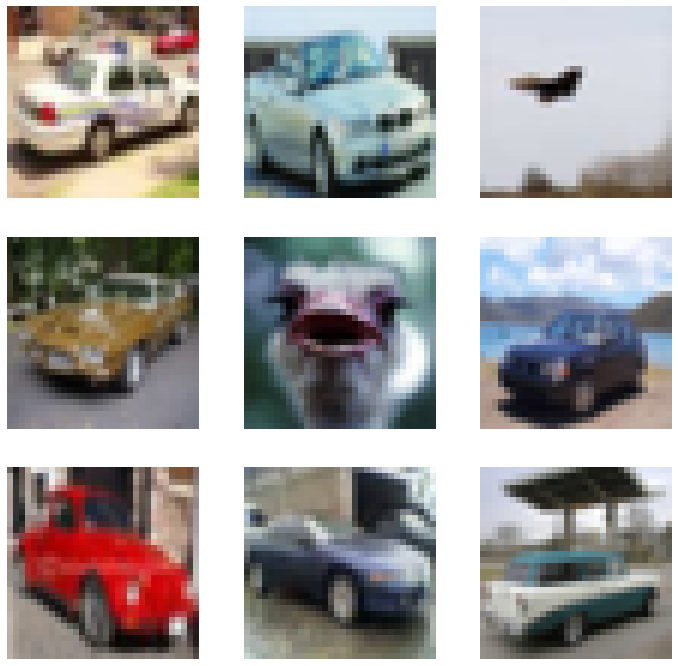

In [3]:
# save x_test images
xx_test = x_test
yy_test = y_test

fig = plt.figure(figsize=(12, 12))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    #print(x_train[i].shape)
    plt.imshow(x_train[i])
plt.show()

In [4]:
# set up image augmentation

rotation_range=30
shift_range=0.30

datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
      )  

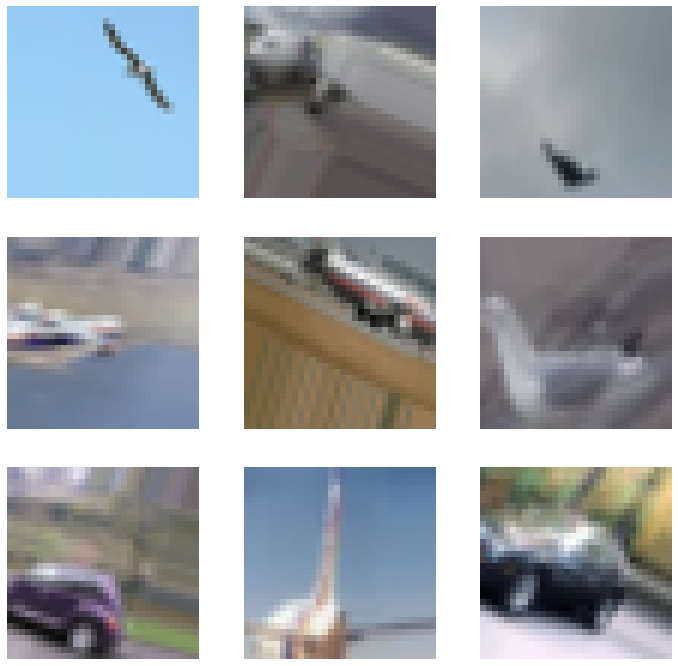

In [5]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
         plt.subplot(330 + 1 + i)
         plt.imshow(X_batch[i].astype(np.uint8))
         plt.axis('off')
    plt.show()
    break

Augmentation of a single image

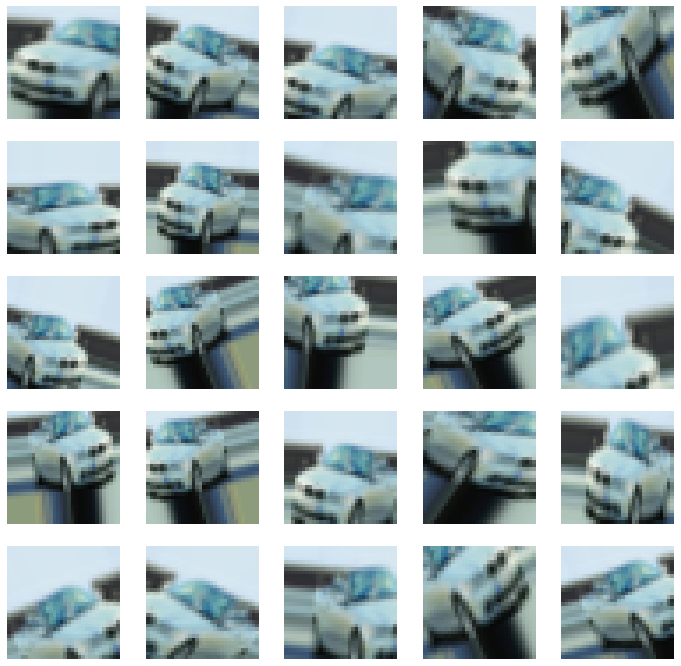

In [6]:
# see example augmentation images
fig = plt.figure(figsize=(12, 12))

for i in range(0, 25):
    for X_batch, y_batch in datagen.flow(x_train[1:3], y_train[1:3], batch_size=1, shuffle=False):
         plt.subplot(5,5,i+1)
         plt.imshow(X_batch[0].astype(np.uint8))
         plt.axis('off')
         break

plt.show()

In [7]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
#input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (500, 32, 32, 3)
500 train samples
3000 test samples


In [8]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")  
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [9]:
 # labels to categorical - output is a vector with length = number of classes
y_train = k.utils.to_categorical(y_train, N_CLASSES)
y_test = k.utils.to_categorical(y_test, N_CLASSES)

# **Optuna & K-FOLDING optimization**





Create convolutional network

In [10]:
def create_model(num_filters2):

  #reg=l2(1e-4)   # L2 or "ridge" regularisation
  reg2=None
  #num_filters2=32
  ac2='relu'
  adm2=Adam(lr=0.01,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt2=adm2
  drop_dense2=0.5
  drop_conv2=0

  model2 = Sequential()

  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Flatten())
  model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
  model2.add(BatchNormalization())
  model2.add(Dropout(drop_dense2))
  model2.add(Dense(N_CLASSES, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

  return model2

Fit convolutional network

In [11]:
def fit_model(model2, datagen, x_train, y_train, x_val, y_val):

  # train with image augmentation

  #es = EarlyStopping(
   # monitor="val_accuracy",
    #patience=60,
    #verbose=1
  #)

  history2=model2.fit(datagen.flow(x_train, y_train, batch_size=128),
                     batch_size=128, epochs=150, validation_data=(x_val, y_val), verbose=0)
  return history2, model2

Optimization using optuna or hyperopt

In [12]:
# OPTUNA

! pip install optuna

import optuna

# or hyperopt
# import hyperopt

     |████████████████████████████████| 286kB 9.1MB/s 
     |████████████████████████████████| 163kB 15.0MB/s 
     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 481kB 15.2MB/s 
     |████████████████████████████████| 133kB 18.5MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 112kB 26.9MB/s 
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=988f28e7d917c9d4eacde46268d25d361451e6ea3a3d2c4cb0c8159f9a7dd7af
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=eb385d5375f8b58588ee7e08408fb42a6ea95cb6baedc76bdb12a936d55b857d
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 sha

Evaluate model with k-folding

In [13]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5, datagen=datagen, num_filters=32):

  scores=[]
  histories=[]
  models=[]

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
      model = create_model(num_filters)
    # select rows for train and test
      trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
      history, model = fit_model(model, datagen, trainX, trainY, testX, testY)
    # evaluate model
      _, acc = model.evaluate(testX, testY, verbose=0)
      print('> %.3f' % (acc * 100.0))
		# stores scores
      scores.append(acc)
      histories.append(history)
      models.append(model)
  return scores, histories, models
  # Here implement k-folding
  # The next 2 lines should be replaced by k_folding
  # select train_ix as indexes of first 80% of traing events and test_ix as last 20%

# **Define objective**

In [14]:
# here define the hyperopt or optuna objective
#def objective(trial):
def objective(trial):    
    
  shift_range=trial.suggest_uniform('shift_range', .00,0.20)
  rotation_range=trial.suggest_uniform('rotation_range', .00,30)
  num_filters=32
    
  # set up image augmentation  

  datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
  )
  datagen.fit(x_train)


    #create and evaluate model
  scores, histories, models = evaluate_model(x_train, y_train, n_folds=5, datagen=datagen, num_filters=num_filters)

  return np.mean(scores)

Run the actual optimization

In [15]:
# Here you should call the optuna/hyperopt optimization replacing the line below
#objective()
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective, n_trials=10, timeout=12000)

[I 2021-01-23 15:59:58,418] A new study created in memory with name: no-name-3ddbbb02-354a-4390-b111-b4eb314dff0e


> 67.000
> 62.000
> 70.000
> 71.000


[I 2021-01-23 16:03:29,642] Trial 0 finished with value: 0.6879999995231628 and parameters: {'shift_range': 0.1228373379847204, 'rotation_range': 27.526322872926873}. Best is trial 0 with value: 0.6879999995231628.


> 74.000
> 73.000
> 76.000
> 65.000
> 74.000


[I 2021-01-23 16:06:47,272] Trial 1 finished with value: 0.6779999971389771 and parameters: {'shift_range': 0.09432271064351123, 'rotation_range': 29.753685111603385}. Best is trial 0 with value: 0.6879999995231628.


> 51.000
> 75.000
> 69.000
> 73.000
> 68.000


[I 2021-01-23 16:10:04,511] Trial 2 finished with value: 0.7100000023841858 and parameters: {'shift_range': 0.1901649826498215, 'rotation_range': 5.155877531595873}. Best is trial 2 with value: 0.7100000023841858.


> 70.000
> 70.000
> 75.000
> 75.000
> 62.000


[I 2021-01-23 16:13:18,971] Trial 3 finished with value: 0.7120000004768372 and parameters: {'shift_range': 0.030315199250938507, 'rotation_range': 24.17870198078214}. Best is trial 3 with value: 0.7120000004768372.


> 74.000
> 73.000
> 63.000
> 62.000
> 80.000


[I 2021-01-23 16:16:36,816] Trial 4 finished with value: 0.7200000047683716 and parameters: {'shift_range': 0.1598021651276249, 'rotation_range': 18.91925451357655}. Best is trial 4 with value: 0.7200000047683716.


> 82.000
> 70.000
> 71.000
> 73.000
> 73.000


[I 2021-01-23 16:19:52,723] Trial 5 finished with value: 0.727999997138977 and parameters: {'shift_range': 0.02237323140104637, 'rotation_range': 15.357050480985013}. Best is trial 5 with value: 0.727999997138977.


> 77.000
> 75.000
> 80.000
> 64.000
> 66.000


[I 2021-01-23 16:23:08,632] Trial 6 finished with value: 0.706000006198883 and parameters: {'shift_range': 0.008724738616718476, 'rotation_range': 29.93021572755592}. Best is trial 5 with value: 0.727999997138977.


> 68.000
> 73.000
> 71.000
> 68.000
> 70.000


[I 2021-01-23 16:26:24,887] Trial 7 finished with value: 0.7019999980926513 and parameters: {'shift_range': 0.07892043946341527, 'rotation_range': 4.56473154541706}. Best is trial 5 with value: 0.727999997138977.


> 69.000
> 75.000
> 72.000
> 69.000
> 73.000


[I 2021-01-23 16:29:41,979] Trial 8 finished with value: 0.7360000133514404 and parameters: {'shift_range': 0.12443952853451055, 'rotation_range': 14.028043253303512}. Best is trial 8 with value: 0.7360000133514404.


> 79.000
> 57.000
> 73.000
> 55.000
> 65.000


[I 2021-01-23 16:33:00,316] Trial 9 finished with value: 0.6139999985694885 and parameters: {'shift_range': 0.17010946381851577, 'rotation_range': 14.074071415026408}. Best is trial 8 with value: 0.7360000133514404.


> 57.000


Print the results

In [16]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.7360000133514404
  Params: 
    shift_range: 0.12443952853451055
    rotation_range: 14.028043253303512


In [17]:
def create_model_2(num_filters2,drop_dense2):

  #reg=l2(1e-4)   # L2 or "ridge" regularisation
  reg2=None
  #num_filters2=32
  ac2='relu'
  adm2=Adam(lr=0.01,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt2=adm2
  drop_dense2=drop_dense2
  drop_conv2=0

  model2 = Sequential()

  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Flatten())
  model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
  model2.add(BatchNormalization())
  model2.add(Dropout(drop_dense2))
  model2.add(Dense(N_CLASSES, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

  return model2

In [18]:
# evaluate a model using k-fold cross-validation
def evaluate_model_2(dataX, dataY, n_folds=5, datagen=datagen, num_filters=32, drop_dense2=0.5):

  scores=[]
  histories=[]
  models=[]

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
      model = create_model_2(num_filters,drop_dense2)
    # select rows for train and test
      trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
      history, model = fit_model(model, datagen, trainX, trainY, testX, testY)
    # evaluate model
      _, acc = model.evaluate(testX, testY, verbose=0)
      print('> %.3f' % (acc * 100.0))
		# stores scores
      scores.append(acc)
      histories.append(history)
      models.append(model)
  return scores, histories, models

In [19]:
def objective_2(trial):    
    
  rotation_range=trial.params.get('rotation_range')
  shift_range=trial.params.get('shift_range')
  num_filters=trial.suggest_uniform('num_filters', .00,45)
  zoom_range=0.13118854236599461
  drop_dense2=trial.suggest_uniform('drop_dense2', .00,0.9)
    
  # set up image augmentation  

  datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=zoom_range
  )
  datagen.fit(x_train)


    #create and evaluate model
  scores, histories, models = evaluate_model_2(x_train, y_train, n_folds=5, datagen=datagen, num_filters=num_filters,drop_dense2=drop_dense2 )

  return np.mean(scores)

In [20]:
# Here you should call the optuna/hyperopt optimization replacing the line below
#objective()
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )
study.optimize(objective_2, n_trials=10, timeout=12000)

[I 2021-01-23 16:33:53,723] A new study created in memory with name: no-name-d6e8c337-6ba0-4b0c-9902-ba9437210d5c


> 76.000
> 76.000
> 77.000
> 78.000


[I 2021-01-23 16:36:57,048] Trial 0 finished with value: 0.7659999847412109 and parameters: {'num_filters': 38.0041544968738, 'drop_dense2': 0.7523414881948646}. Best is trial 0 with value: 0.7659999847412109.


> 76.000
> 66.000
> 65.000
> 52.000
> 67.000


[I 2021-01-23 16:39:56,176] Trial 1 finished with value: 0.6440000057220459 and parameters: {'num_filters': 26.111142482345986, 'drop_dense2': 0.26297101285710583}. Best is trial 0 with value: 0.7659999847412109.


> 72.000
> 71.000
> 75.000
> 66.000
> 72.000


[I 2021-01-23 16:42:50,514] Trial 2 finished with value: 0.7080000042915344 and parameters: {'num_filters': 9.266228449343165, 'drop_dense2': 0.33580583812594433}. Best is trial 0 with value: 0.7659999847412109.


> 70.000
> 72.000
> 50.000
> 66.000
> 81.000


[I 2021-01-23 16:45:48,269] Trial 3 finished with value: 0.6840000152587891 and parameters: {'num_filters': 23.890786829648874, 'drop_dense2': 0.18494979946976112}. Best is trial 0 with value: 0.7659999847412109.


> 73.000
> 77.000
> 82.000
> 73.000
> 62.000


[I 2021-01-23 16:48:51,288] Trial 4 finished with value: 0.7059999942779541 and parameters: {'num_filters': 37.200858770175564, 'drop_dense2': 0.353508385160855}. Best is trial 0 with value: 0.7659999847412109.


> 59.000
> 73.000
> 80.000
> 75.000
> 72.000


[I 2021-01-23 16:51:54,792] Trial 5 finished with value: 0.7500000119209289 and parameters: {'num_filters': 42.12795572530014, 'drop_dense2': 0.693103100970318}. Best is trial 0 with value: 0.7659999847412109.


> 75.000
> 85.000
> 62.000
> 63.000
> 74.000


[I 2021-01-23 16:54:47,073] Trial 6 finished with value: 0.6900000095367431 and parameters: {'num_filters': 16.44290938336574, 'drop_dense2': 0.6839486091864204}. Best is trial 0 with value: 0.7659999847412109.


> 61.000
> 51.000
> 67.000
> 57.000
> 75.000


[I 2021-01-23 16:57:35,537] Trial 7 finished with value: 0.6299999952316284 and parameters: {'num_filters': 3.35608511648974, 'drop_dense2': 0.2624025506738634}. Best is trial 0 with value: 0.7659999847412109.


> 65.000
> 66.000
> 65.000
> 67.000
> 69.000


[I 2021-01-23 17:00:32,636] Trial 8 finished with value: 0.6800000071525574 and parameters: {'num_filters': 28.927005706286447, 'drop_dense2': 0.35569406436013823}. Best is trial 0 with value: 0.7659999847412109.


> 73.000
> 65.000
> 76.000
> 68.000
> 75.000


[I 2021-01-23 17:03:21,825] Trial 9 finished with value: 0.7120000004768372 and parameters: {'num_filters': 4.422986578259965, 'drop_dense2': 0.23923103148835365}. Best is trial 0 with value: 0.7659999847412109.


> 72.000


In [21]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.7659999847412109
  Params: 
    num_filters: 38.0041544968738
    drop_dense2: 0.7523414881948646


In [22]:
def create_model_3(num_filters2):

  #reg=l2(1e-4)   # L2 or "ridge" regularisation
  reg2=None
  #num_filters2=32
  ac2='relu'
  adm2=Adam(lr=0.01,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  opt2=adm2
  drop_dense2=trial.params.get('drop_dense2')
  drop_conv2=0

  model2 = Sequential()

  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
  model2.add(BatchNormalization(axis=-1))
  model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
  model2.add(Dropout(drop_conv2))

  model2.add(Flatten())
  model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
  model2.add(BatchNormalization())
  model2.add(Dropout(drop_dense2))
  model2.add(Dense(N_CLASSES, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

  return model2

In [23]:
def evaluate_model_3(dataX, dataY, n_folds=5, datagen=datagen, num_filters=32):

  scores=[]
  histories=[]
  models=[]

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
      model = create_model_3(num_filters)
    # select rows for train and test
      trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
    # fit model
      history, model = fit_model(model, datagen, trainX, trainY, testX, testY)
    # evaluate model
      _, acc = model.evaluate(testX, testY, verbose=0)
      print('> %.3f' % (acc * 100.0))
		# stores scores
      scores.append(acc)
      histories.append(history)
      models.append(model)
  return scores, histories, models

# **Train with optimized parameters**

In [24]:
shift_range=shift_range
rotation_range=rotation_range
num_filters=trial.params.get('num_filters')

# here you should get parameters from optimization (the lines below should be updated)
#num_filters = 32
#rotation_range = 5
#shift_range = 0.1


# set up image augmentation
datagen = ImageDataGenerator( 
      rotation_range=rotation_range,
      horizontal_flip=True,
      width_shift_range=shift_range,
      height_shift_range=shift_range,
      zoom_range=shift_range
)
datagen.fit(x_train)


#create and evaluate model
scores, histories, models = evaluate_model_3(x_train, y_train, n_folds=5, datagen=datagen)

> 56.000
> 52.000
> 63.000
> 74.000
> 69.000


# **Make plots**

In [25]:
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['accuracy','val_accuracy'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()

# **Summarize**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



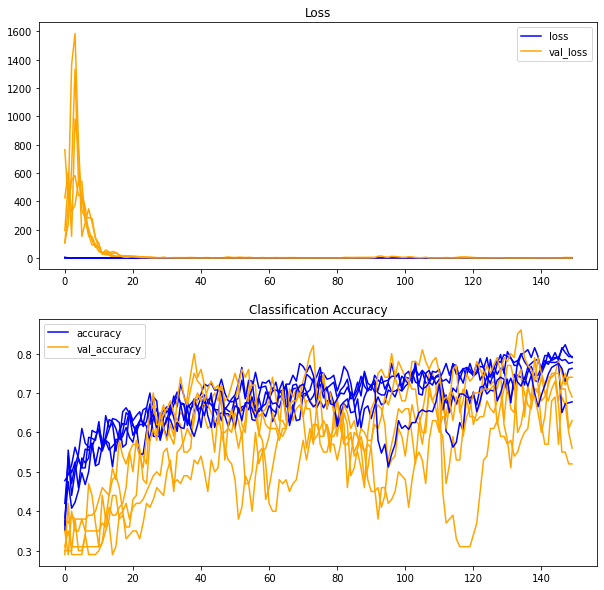

Accuracy: mean=62.800 std=8.085, n=5


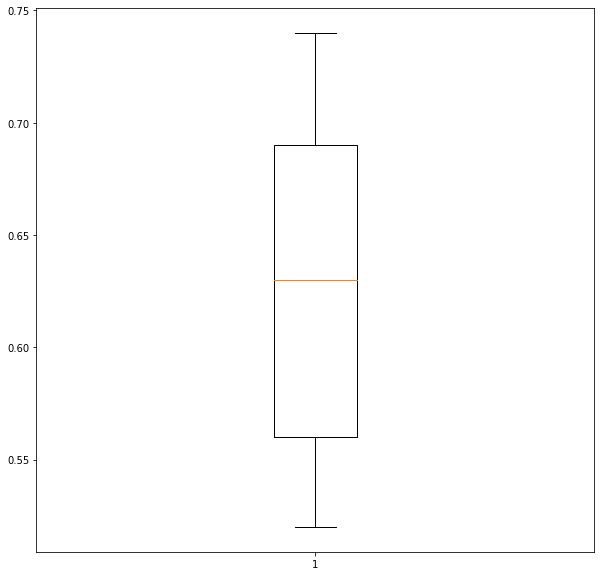

Scores:  [0.5600000023841858, 0.5199999809265137, 0.6299999952316284, 0.7400000095367432, 0.6899999976158142]


In [26]:
# learning curves
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)

# **Ensamble of networks - build one classifier as an average of n models from variable models**

In [27]:
# make predictions
yhats = [model.predict(x_test) for model in models]
yhats = np.array(yhats)
#print(yhats)
# sum across ensembles
summed = np.sum(yhats, axis=0)/len(models)
#print(summed)
# argmax across classes
outcomes = np.argmax(summed, axis=1)
#print(outcomes.shape)
#print(outcomes)
# true outcomes
outcomes_true = np.argmax(y_test,axis = 1)
#print(outcomes_true.shape)
#print(outcomes_true)

score = (len(outcomes) - np.count_nonzero(outcomes-outcomes_true))/len(outcomes)

print("Ensamble test accuracy: ",score*100.,"%")


Ensamble test accuracy:  68.76666666666667 %


In [28]:
# Confusion matrix result

from sklearn.metrics import classification_report, confusion_matrix


#confusion matrix
cm = confusion_matrix(outcomes_true,outcomes)
print(cm)



[[540 397  63]
 [ 13 979   8]
 [140 316 544]]




# **Plot images for the ensamble of models**

In [29]:
def plot_images2(y_pred, y_pred_prob):
# Names of predicted classes (randomly chosen images)

  import random


  class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

  #y_pred = model2.predict_classes(x_test)
  #y_pred_prob = model2.predict(x_test)

  grid_w = 10
  grid_h = 10

  fig = plt.figure(figsize=(20, 40))
  for i in range(0,grid_w*grid_h):
    i_pos = 2*(int(i/grid_w))*grid_w+ i%grid_w + 1
    #print(i_pos)
    plt.subplot(2*grid_h, grid_w, i_pos)
    i_img = random.randint(0,len(xx_test))
    plt.imshow(xx_test[i_img])
    #plt.bar([0,1,2,3,4,5,6,7,8,9],y_test[i_img])
    plt.axis('off')
    if yy_test[i_img] == y_pred[i_img]:
      plt.text(0, -2, class_names[int(yy_test[i_img])], color='green', fontsize=12)
    else:
      plt.text(0, -2, class_names[int(yy_test[i_img])]+" "+class_names[y_pred[i_img]], color='red', fontsize=12)  
    plt.subplot(2*grid_h, grid_w, i_pos + grid_w)
    xbar = np.linspace(1, N_CLASSES, num=N_CLASSES)
    plt.bar(xbar,y_pred_prob[i_img])
    plt.axis('off')

  plt.show()

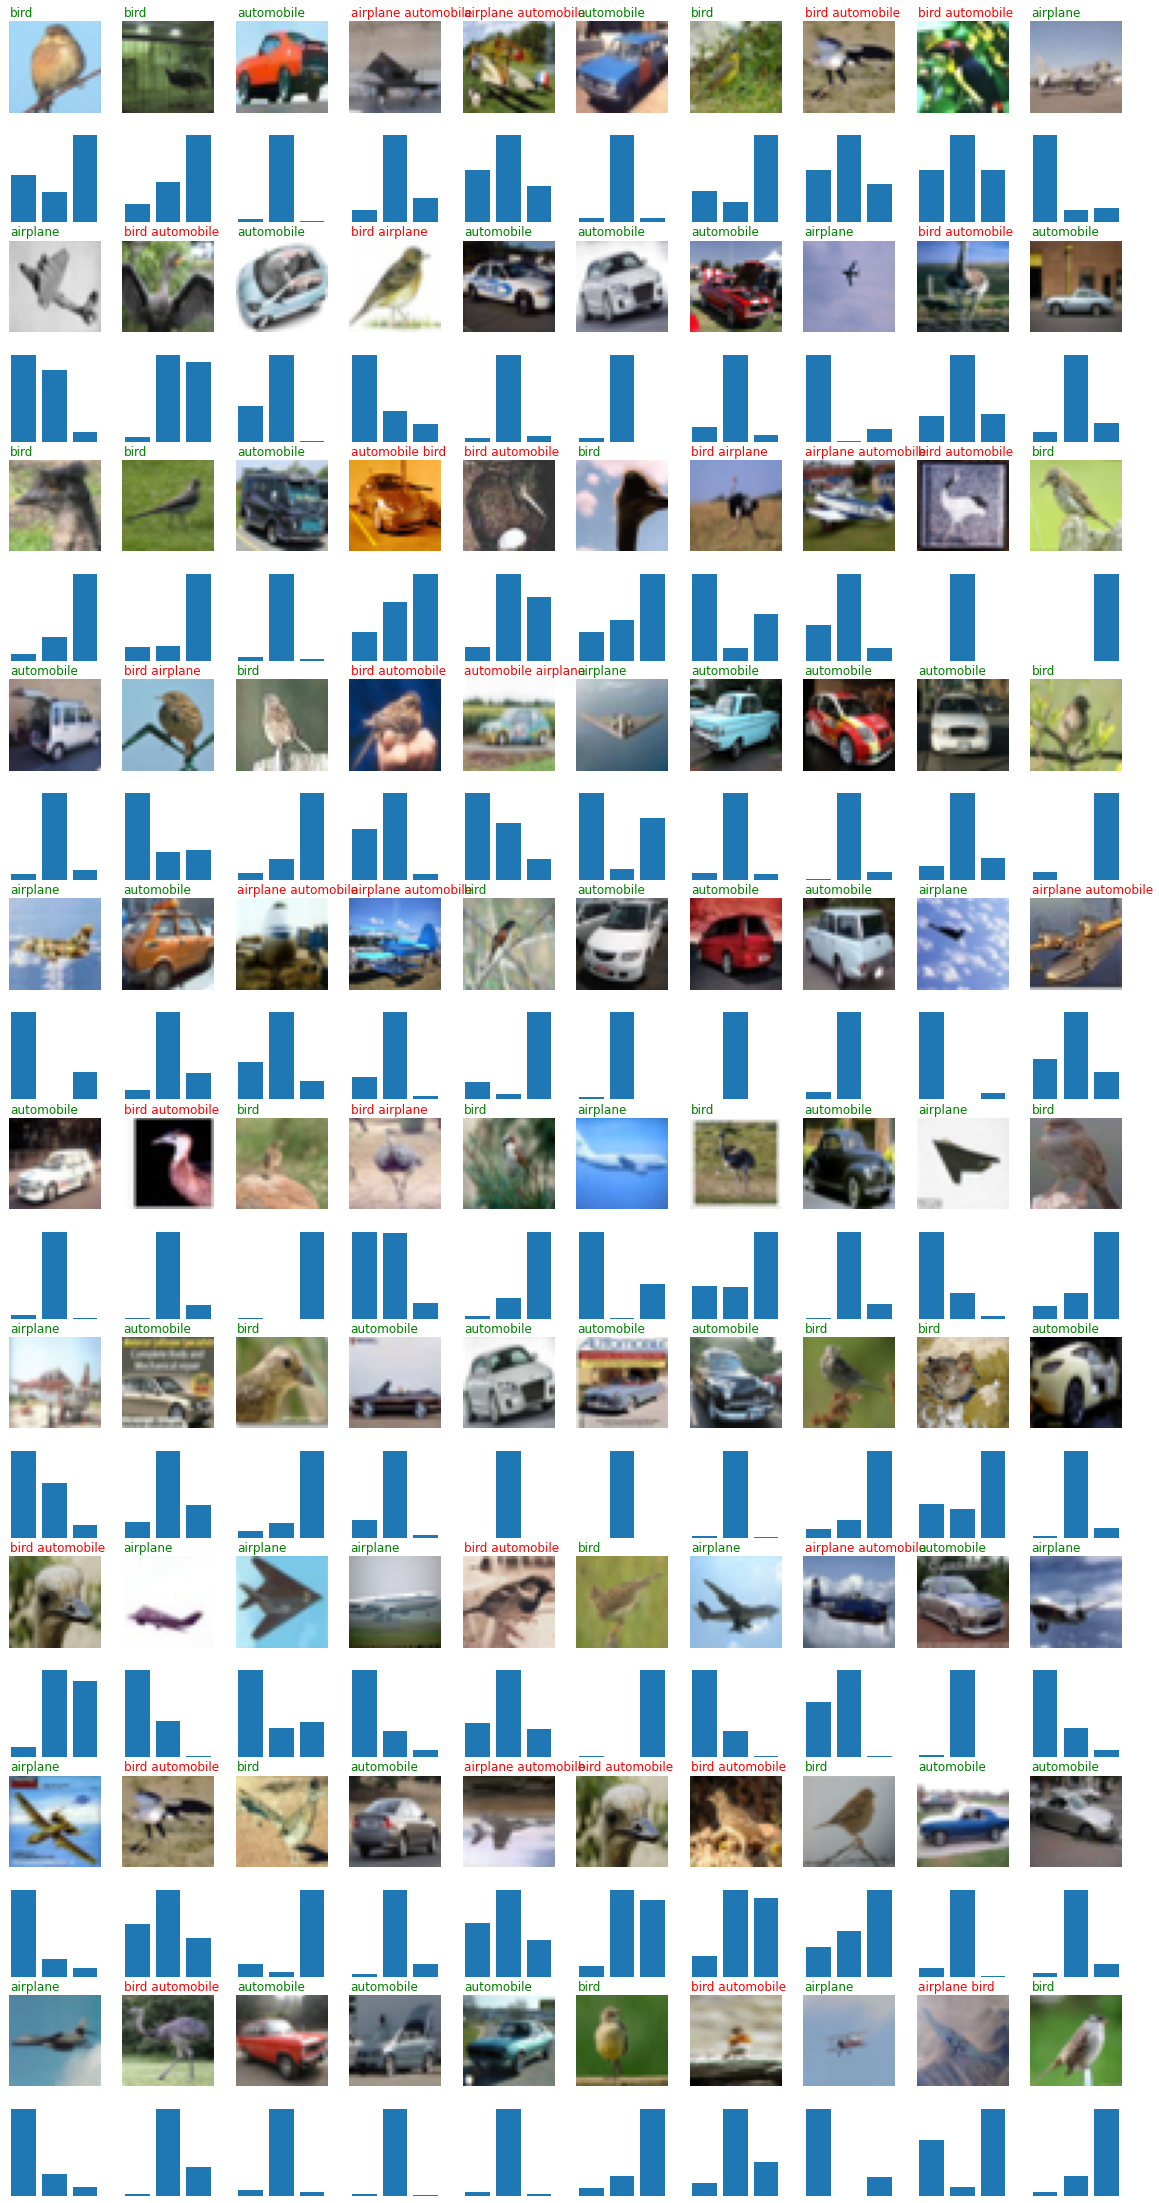

In [30]:
plot_images2(outcomes,summed)

## Visualizing the Optimization History

In [31]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [32]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

## Visualizing Parameter Relationships

In [33]:
from optuna.visualization import plot_contour

plot_contour(study)

## Visualizing Individual Parameters

In [34]:
from optuna.visualization import plot_slice

plot_slice(study)

## Visualizing Parameter Importances

In [35]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)